In [1]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

# Pre-training results


In [2]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np
import pandas as pd
import toml
import os
import glob

# from presentation.pipelines.steps.load_data import build_loader
# from presentation.pipelines.steps.model_design import load_pt_model

from src.utils import tensorboard_logs

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

2024-10-23 10:18:53.949816: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 10:18:53.949867: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 10:18:53.949906: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 10:18:54.044856: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [52]:
TAG = 'final' # should match the name of the hyperparameter in config.toml 
model_paths = glob.glob(os.path.join('./presentation/results/{}/'.format(TAG), '*', 'pretraining'))
    
if TAG == 'best_0_to_1':
    model_paths+=['./presentation/results/temperature/2024-09-20_12-25-37/pretraining/']

In [53]:
sorted_path = np.array(model_paths.copy())
index_value = []
for path in model_paths:
    with open(os.path.join(path, 'config.toml'), 'r') as file:
        conf = toml.load(file)
        
        if TAG == 'final':
            index_value.append(path.split('/')[-2])
                
        if TAG == 'new':
            if conf['exp_name'] == 'paper':
                index_value.append('paper')
            else:
                index_value.append(conf['mask_format'])
            
        if TAG == 'best_0_to_1':
            value=''
            if conf['use_leak']:
                value = 'Base + Res. + '
            if not conf['no_msk_token']:
                value += '[MSK]'
            if conf['exp_name'] == 'temperature':
                value += 'Base'                
            index_value.append(value)
        
        if TAG == 'astromer_1':
            if conf['use_leak']:
                value = 'a1 + leak'  
            if not conf['use_leak']:
                value = 'a1'
            index_value.append(value)
            
        if TAG == 'n_samples':
            index_value.append(int(conf['data'].split('/')[-3]))
        
        if TAG == 'ckpt':
            index_value.append(int(path.split('/')[-2].split('_')[-1]))
            
        if TAG in ['temperature', 'm_alpha', 'probed']:
            index_value.append(conf[TAG])

index_value    = np.array(index_value)
sorted_indices = np.argsort(index_value)
sorted_path    = list(sorted_path[sorted_indices])
sorted_labels  = list(index_value[sorted_indices])
# sorted_path = sorted_path[:-1]
sorted_labels

['v0', 'v0.1', 'v0.2', 'v1.0']

## Learning curves

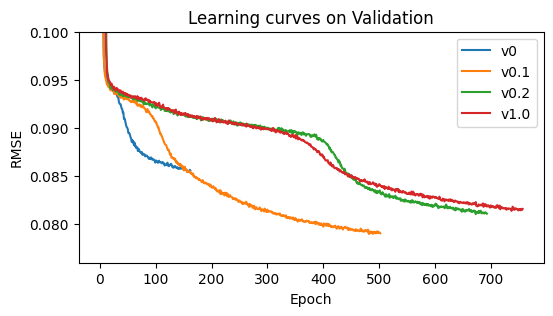

In [80]:
plt.figure(figsize=(6,3), dpi=300)
for k, path in enumerate(sorted_path):
    train_metrics, val_metrics = tensorboard_logs(path)
    
    if TAG in ['best_0_to_1', 'astromer_1', 'new', 'final']:
        if 'loss' not in train_metrics.columns:
            train_metrics = train_metrics.rename(columns={'rmse': 'loss'})
            val_metrics = val_metrics.rename(columns={'rmse': 'loss'})
        label = sorted_labels[k]             
    
    if TAG == 'n_samples':
        a = int(train_metrics['data'].iloc[0].split('/')[-3])
        label = r'N={:.0f}'.format(a)
        
    if TAG == 'ckpt':
        label = r'Epoch {}'.format(path.split('/')[-2].split('_')[-1])
        
    if TAG == 'temperature':
        label = r'$\tau$={:.2f}'.format(train_metrics['temperature'].iloc[0])
    
    if TAG == 'probed':
        label = train_metrics['probed'].iloc[0]
        
    if TAG == 'm_alpha':
        val = train_metrics['m_alpha'].iloc[0]
        if float(val) == -1e9:
            label = r'$\alpha$=$-\infty$'
        else:
            label = r'$\alpha$={:.0f}'.format(val)
            
    plt.plot(val_metrics['step'], val_metrics['loss'], label=label)
    # plt.yscale('log')
plt.legend(bbox_to_anchor=(1., 1.0))
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.title('Learning curves on Validation')
if TAG == 'final':
     plt.ylim(0.076, 0.1)
    
if TAG == 'n_samples':
    plt.ylim(2e-3, 0.3)
if TAG == 'm_alpha':
    plt.ylim(6.3e-2, 6.8e-2)
if TAG == 'temperature':
    plt.ylim(5e-2, 7e-2)

plt.show()


In [55]:
sorted_labels

['v0', 'v0.1', 'v0.2', 'v1.0']

### Number of samples

In [81]:
x_plot, y1_plot, y2_plot = [], [], []

for k, logs in enumerate(sorted_path):
    train_metrics, val_metrics = tensorboard_logs(logs)
    row = val_metrics[val_metrics['rmse'].astype('float').values == val_metrics['rmse'].min()]
    
    y1_plot.append(float(row['rmse'].values[0]))
    if 'rsquare' not in val_metrics.columns:
        y2_plot.append(0.8)
    else:
        y2_plot.append(float(row['rsquare'].values[0]))
    
    if TAG == 'n_samples':
        value = int(row['data'].values[0].split('/')[-3])
    if TAG == 'm_alpha':
        value = row['m_alpha'].iloc[0]
    if TAG == 'ckpt':
        value = logs.split('/')[-2].split('_')[-1]
    if TAG == 'temperature':
        value = row['temperature'].iloc[0]
    if TAG == 'probed':
        value = row['probed'].iloc[0]
    if TAG in ['astromer_1', 'best_0_to_1', 'new', 'final']:
        value = sorted_labels[k]              
    x_plot.append(value)

In [82]:
x_plot  = np.array(x_plot)
y1_plot = np.array(y1_plot)
y2_plot = np.array(y2_plot)
test_metrics_pt = []
for i, path in enumerate(sorted_path):
    curr = os.path.join(path, 'results.csv')
    try:
        partial_df = pd.read_csv(curr)
    except:
        partial_df = pd.DataFrame({'test_mse': [0.], 'test_r2': [0.]})
        
    partial_df[TAG] = x_plot[i]
    # if TAG == 'astromer_1':
    #     partial_df['astromer_1'] = x_plot[i]
    # if TAG == 'best_0_to_1':
    #     partial_df['best_0_to_1'] = x_plot[i]
    # if TAG == 'ckpt':
    #     partial_df['ckpt'] = x_plot[i]
    # if TAG == 'n_samples':
    #     partial_df['n_samples'] = x_plot[i]
    # if TAG == 'new':
    #     partial_df['new'] = x_plot[i]
        
    test_metrics_pt.append(partial_df)

test_metrics_pt = pd.concat(test_metrics_pt)  

In [83]:
df = pd.DataFrame()
df[TAG] = x_plot
df['val_rmse'] = y1_plot
df['val_r2'] = y2_plot
df_1 = test_metrics_pt[[TAG, 'test_mse', 'test_r2']]
df_2 = pd.merge(df, df_1, on=TAG)
df_2 = df_2.round(3)
df_2

,final,val_rmse,val_r2,test_mse,test_r2
0,v0,0.085,0.760,0.000,0.000
1,v0.1,0.079,0.794,0.071,0.771
2,v0.2,0.081,0.784,0.071,0.762
3,v1.0,0.081,0.782,0.072,0.766


In [84]:
x_plot

array(['v0', 'v0.1', 'v0.2', 'v1.0'], dtype='<U4')

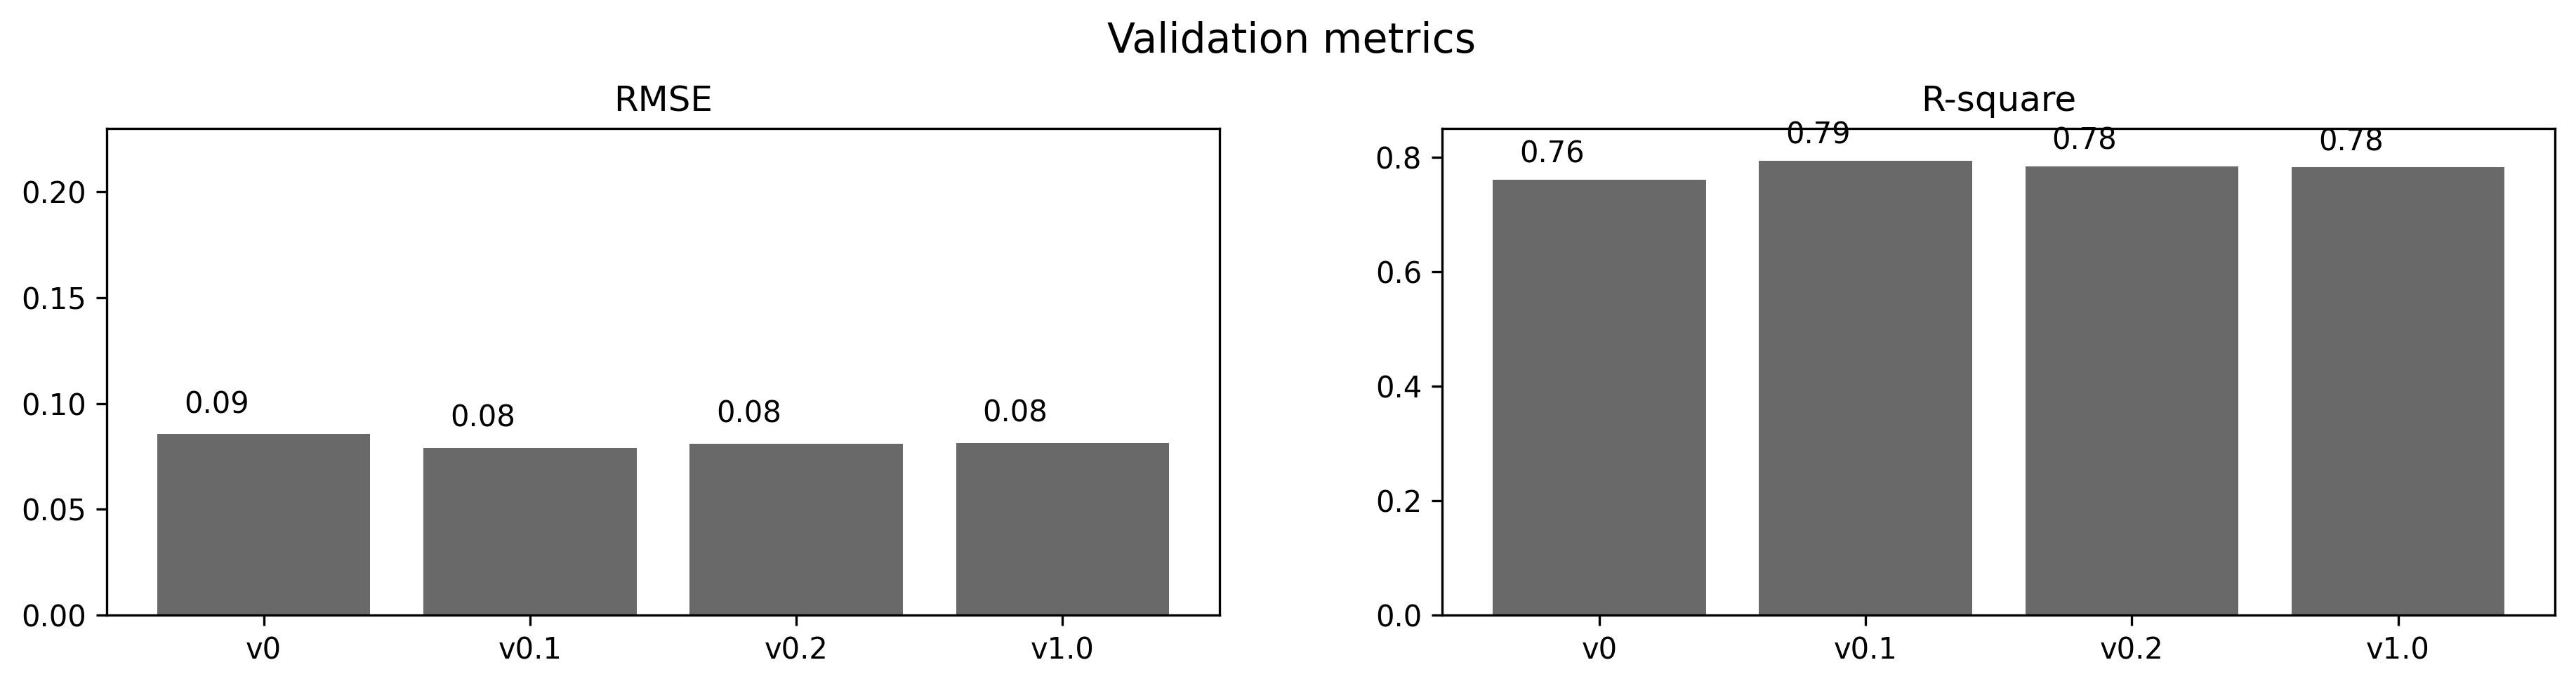

In [85]:
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(15, 3))
xticks = range(len(x_plot))
if TAG == 'probed':
    x_plot_ = [0.1, 0.2, 0.3, 0.4, 0.5]
if TAG == 'temperature':
    x_plot_ = [0.5, 1, 1.5, 2, 2.5, 3]
if TAG == 'n_samples':
    x_plot_ = ['$10^2$', '$10^3$', '$10^4$', '$10^5$', '$500.000$']
if TAG == 'm_alpha':
    x_plot_ = ['$-\infty$', '$-10^3$', '$-10^2$', '$-10$', '$-1$', '$0$', '$1$']
if TAG in ['astromer_1', 'best_0_to_1', 'new', 'ckpt', 'final']:
    x_plot_ = x_plot

axes[0].bar(xticks, y1_plot, color='dimgray')
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(x_plot_, rotation=0)
axes[0].set_title('RMSE')
axes[0].set_ylim(0, 0.23)
for i, value in enumerate(y1_plot):
    axes[0].text(i-.3, value+0.01, '{:.2f}'.format(value))

axes[1].bar(xticks, y2_plot, color='dimgray')
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(x_plot_, rotation=0)
for i, value in enumerate(y2_plot):
    if i < 3 and TAG == 'n_samples':
        axes[1].text(i-.3, 0.03, '{:.2f}'.format(value))
    else:
        axes[1].text(i-.3, value+0.03, '{:.2f}'.format(value))

axes[1].set_title('R-square')
if TAG == 'n_samples':
    axes[1].set_ylim(-0.2, 0.85)
else:
    axes[1].set_ylim(-0., 0.85)

fig.text(0.5, 1., 'Validation metrics', ha='center', fontsize=14)
if TAG == 'temperature':
    fig.text(0.5, -0.03, r'Temperature ($\tau$)', ha='center', fontsize=12)
if TAG == 'm_alpha':
    fig.text(0.5, -0.03, r'Soft-masking scaling term ($\alpha$)', ha='center', fontsize=12)
if TAG == 'n_samples':
    fig.text(0.5, -0.03, r'Number of pretraining samples', ha='center', fontsize=12)
if TAG == 'ckpt':
    fig.text(0.5, -0.03, r'Checkpoint epoch', ha='center', fontsize=12)
if TAG == 'best_0_to_1':
    fig.text(0.5, -0.03, r'New architecture feature', ha='center', fontsize=12)
    
fig.savefig('./presentation/figures/{}_val.pdf'.format(TAG), format='pdf', bbox_inches='tight')  
plt.show()

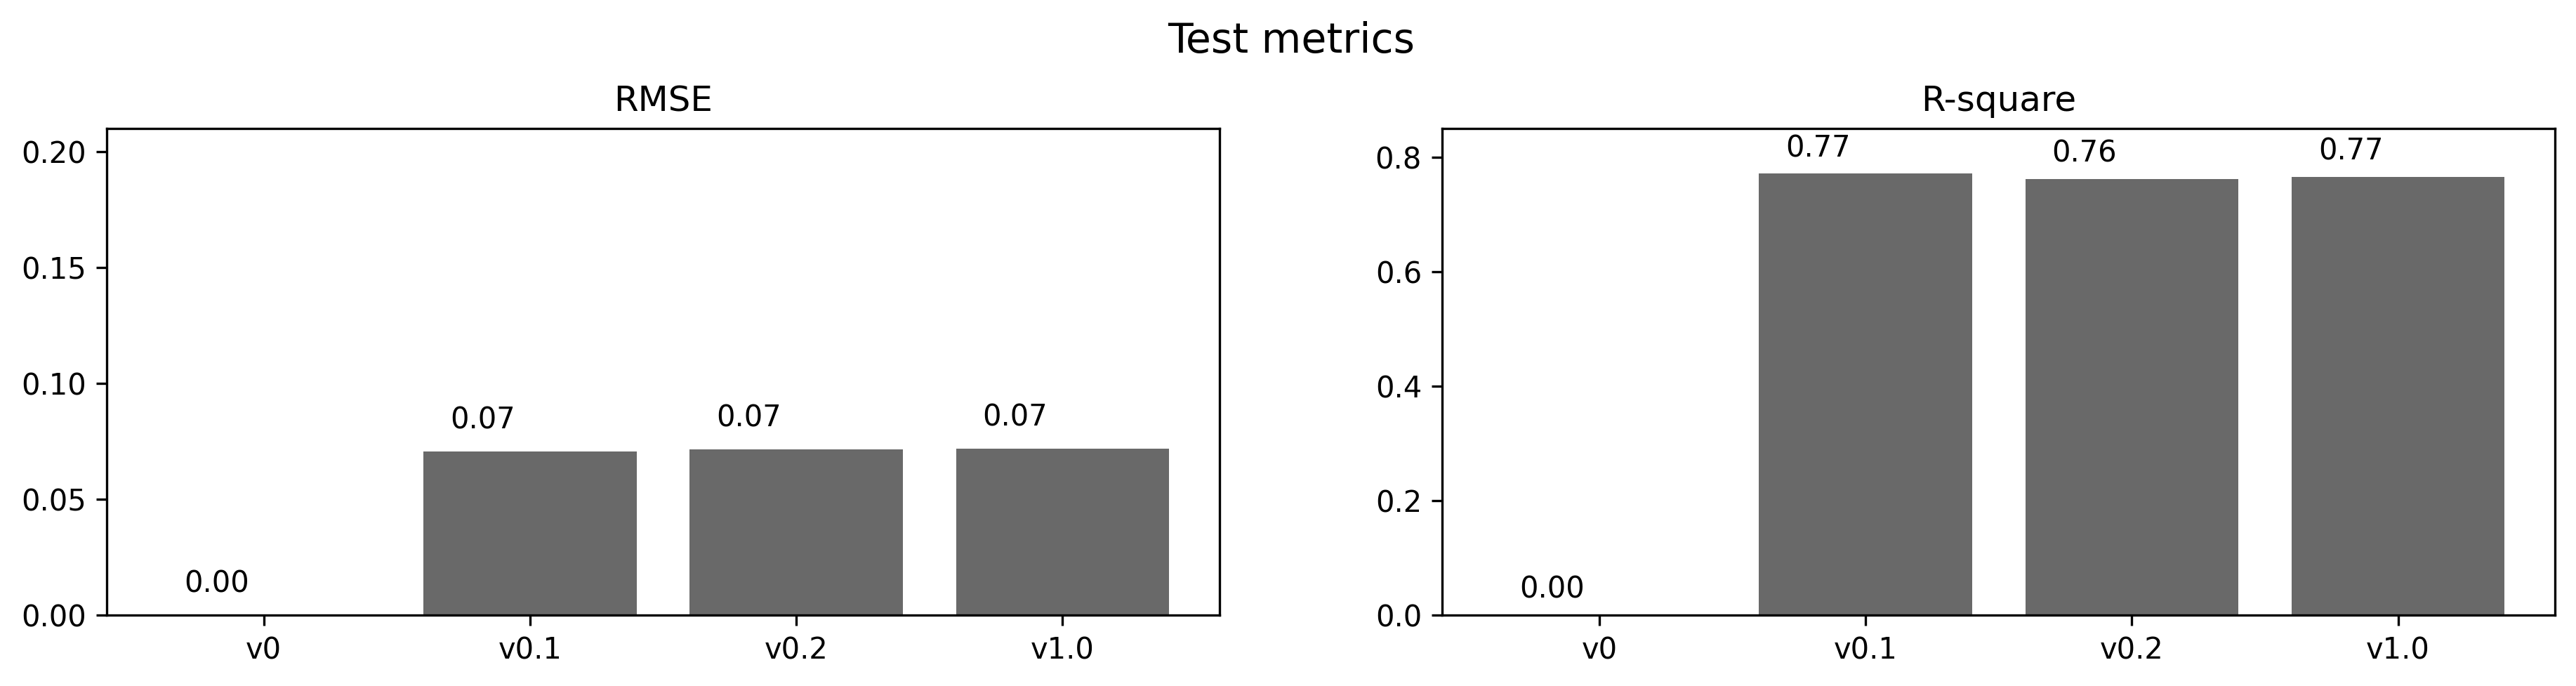

In [86]:
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(15, 3))

axes[0].bar(xticks, test_metrics_pt['test_mse'], color='dimgray')
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(x_plot_, rotation=0)
axes[0].set_title('RMSE')
axes[0].set_ylim(0, 0.21)

for i, value in enumerate(test_metrics_pt['test_mse']):
    axes[0].text(i-.3, value+0.01, '{:.2f}'.format(value))

axes[1].bar(xticks, test_metrics_pt['test_r2'], color='dimgray')
axes[1].set_xticks(xticks)

axes[1].set_xticklabels(x_plot_, rotation=0)

for i, value in enumerate(test_metrics_pt['test_r2']):
    if i < 3 and TAG == 'n_samples':
        axes[1].text(i-.3, 0.03, '{:.2f}'.format(value))
    else:
        axes[1].text(i-.3, value+0.03, '{:.2f}'.format(value))
    
axes[1].set_title('R-square')
if TAG == 'n_samples':
    axes[1].set_ylim(-0.6, 0.85)
else:
    axes[1].set_ylim(-0., 0.85)

fig.text(0.5, 1., 'Test metrics', ha='center', fontsize=14)
if TAG == 'temperature':
    fig.text(0.5, -0.03, r'Temperature ($\tau$)', ha='center', fontsize=12)
if TAG == 'm_alpha':
    fig.text(0.5, -0.03, r'Soft-masking scaling term ($\alpha$)', ha='center', fontsize=12)
if TAG == 'n_samples':
    fig.text(0.5, -0.03, r'Number of pretraining samples', ha='center', fontsize=12)
if TAG == 'best_0_to_1':
    fig.text(0.5, -0.03, r'New architecture feature', ha='center', fontsize=12)
    
fig.savefig('./presentation/figures/{}_test.pdf'.format(TAG), format='pdf', bbox_inches='tight')  
plt.show() 

### Classification

In [87]:
from presentation.pipelines.pipeline_0.utils import classification_metrics

In [88]:
paper = classification_metrics(os.path.join('./presentation/results/paper/'), 
                               spc_list=[20, 100, 500])

In [89]:
test_metrics = [] 
for i, root in enumerate(sorted_path):
    curr = classification_metrics(os.path.join(root, '..'), spc_list=[20, 100, 500], clf_arch='avg_mlp')
    if TAG in ['n_samples', 'ckpt', 'best_0_to_1', 'astromer_1', 'new', 'final']:
        curr[TAG] = [x_plot_[i]]*curr.shape[0]
    test_metrics.append(curr)
test_metrics = pd.concat(test_metrics)

In [90]:
if TAG == 'ckpt':
    train_metrics, val_metrics = tensorboard_logs('./presentation/results/ckpt/epoch_0/pretraining/')
    
    
    for sset in ['alcock', 'atlas']:
        fig, ax = plt.subplots(1, 3, figsize=(15, 3), sharey=True, gridspec_kw={'wspace': 0.3}, dpi=300)
        for i, SPC in enumerate([20, 100, 500]):
            test_selected = test_metrics[(test_metrics['spc'] == SPC) & (test_metrics['data'] == sset)][['ckpt', 'mean', 'std']]
            x = test_selected['ckpt'].astype(int)
            y = test_selected['mean']
            yerr = test_selected['std']
            
            
            ax[i].plot(val_metrics['step'], val_metrics['loss'], color='k')
            ax[i].set_ylabel('Validation RMSE')
            
            ax2 = ax[i].twinx()
            ax2.errorbar(x[:-1], y[:-1], yerr=yerr[:-1], marker='.', color='darkred')
            ax2.axhline(y=y.iloc[-1], color='darkgreen', linestyle='--', label='Best (epoch {})'.format(x.iloc[-1]))
            ax2.set_ylabel('F1 Score (3-fold mean)')
            ax2.set_xticks(x.iloc[:-1])
            ax[i].set_xticklabels(x.iloc[:-1], rotation=45)

            if sset == 'alcock':
                plt.title('MACHO \n{} samples per class'.format(SPC))
            if sset == 'atlas':
                plt.title('ATLAS \n{} samples per class'.format(SPC))
                
            lines1, labels1 = ax[i].get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax[i].legend(lines1 + lines2, labels1 + labels2, loc='center right')
        fig.savefig('./presentation/figures/clf_ckpt_{}.pdf'.format(sset), format='pdf', bbox_inches='tight')
    plt.show()

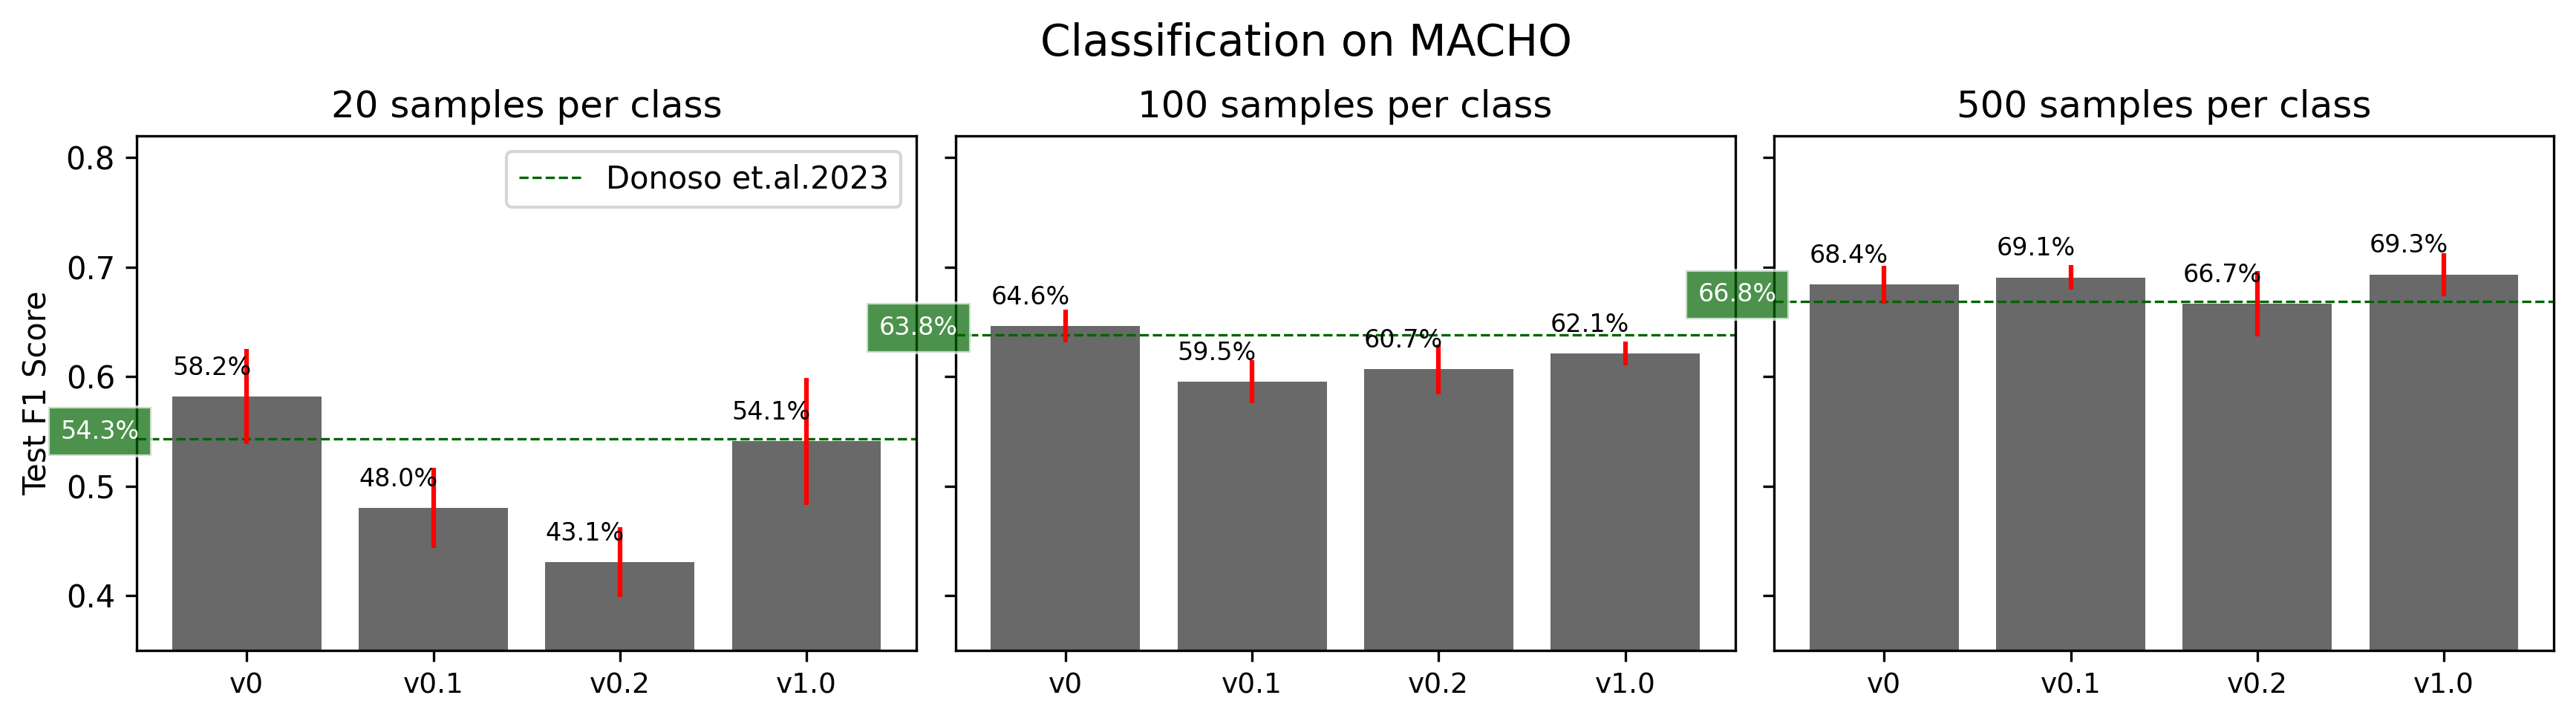

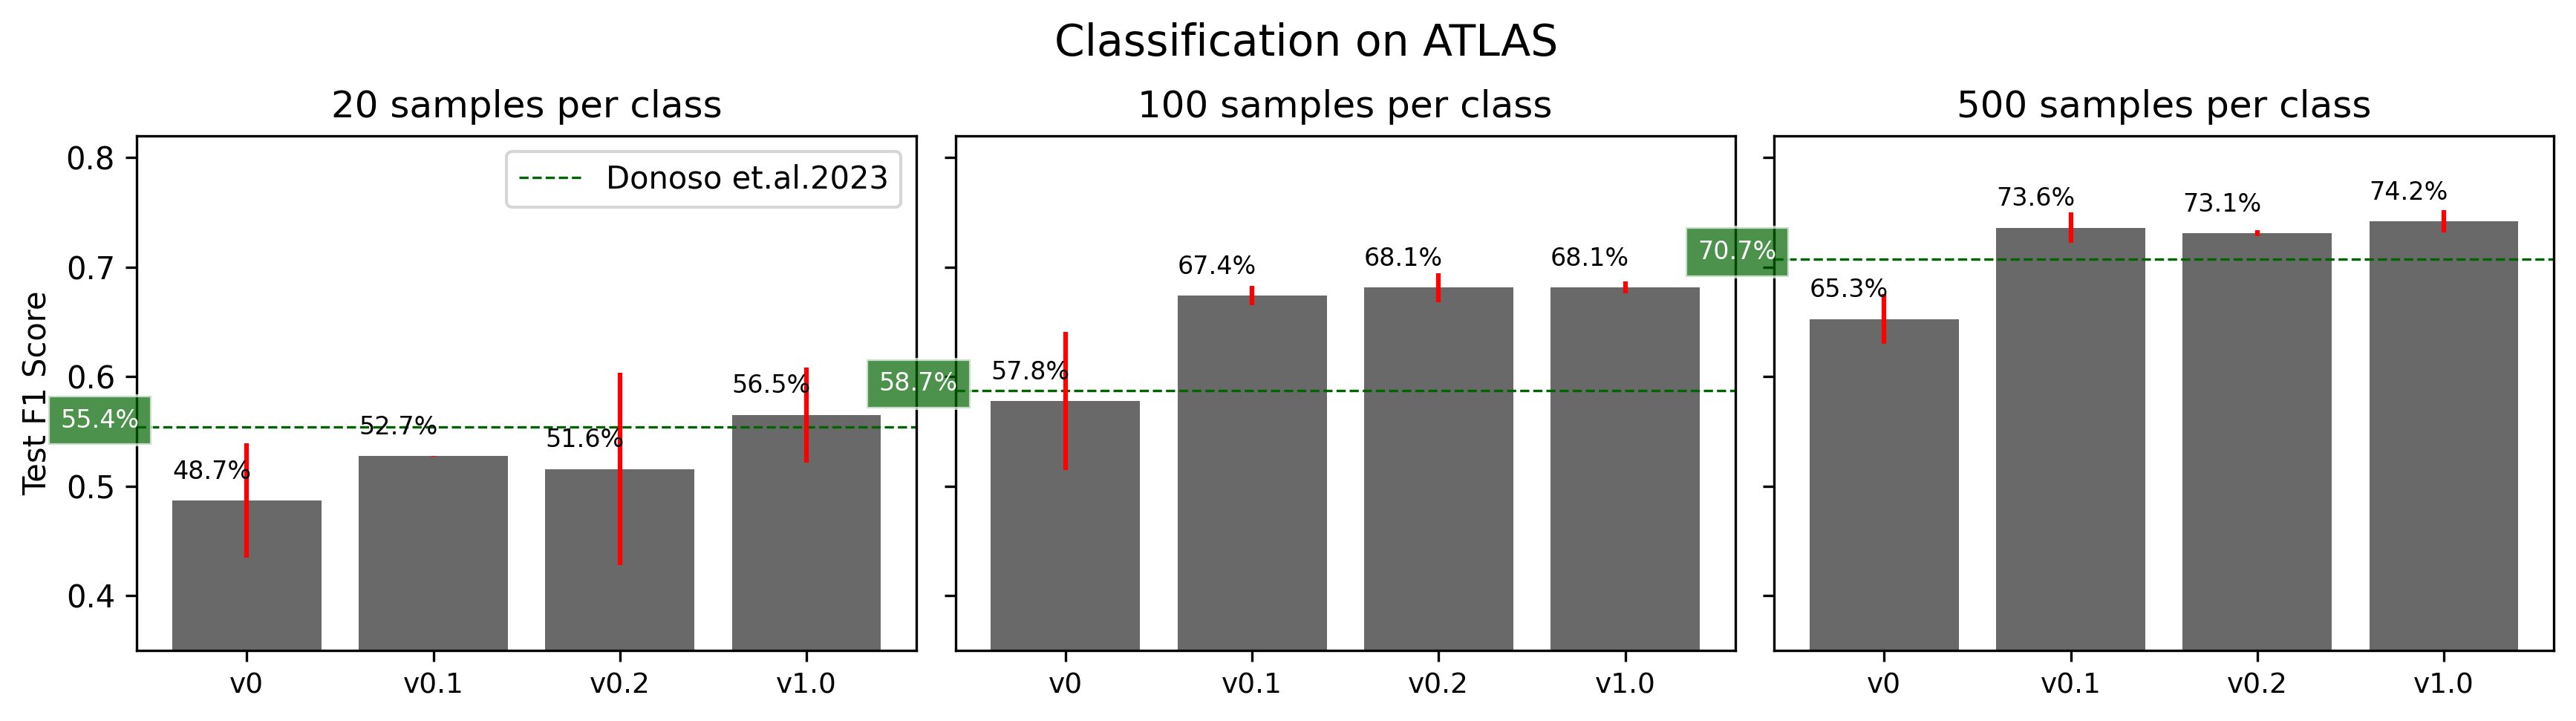

In [91]:
for group0, df0 in test_metrics.groupby('data'):
    fig, axes = plt.subplots(1, 3, figsize=(14, 3), sharey=True, dpi=300, gridspec_kw={'wspace': 0.05})
    for k, (group1, df1) in enumerate(df0.groupby('spc')):
        if TAG not in ['best_0_to_1', 'astromer_1', 'new', 'final']:
            df1[TAG] = df1[TAG].astype(float)
            df1 = df1.sort_values(TAG)

        selpaper = paper[(paper['data'] == group0) & (paper['spc'] == group1)]
        
        xticks = range(df1[TAG].shape[0])
        yv = df1['mean'].values
        xv = list(xticks)
        ye = df1['std'].values

        axes[k].axhline(y=selpaper['mean'].values[0], color='darkgreen', linestyle='--', linewidth=0.8, label='Donoso et.al.2023')
        t = axes[k].text(xticks[0]-1, selpaper['mean'].values[0], 
                     '{:.1f}%'.format(selpaper['mean'].values[0]*100), fontsize=8, color='w', rotation=0)
        
        
        t.set_bbox(dict(facecolor='darkgreen', alpha=0.7, edgecolor='white'))
        
        axes[k].bar(xv, yv, yerr=ye, color='dimgray', ecolor='red')
        axes[k].set_xticks(xticks)
        axes[k].set_xticklabels(df1[TAG], rotation=0, fontsize=9)
        axes[k].set_title('{} samples per class'.format(group1))
        if TAG == 'n_samples':
            axes[k].set_ylim(0., 0.65)
        else:
            axes[k].set_ylim(0.35, 0.82)

        if TAG == 'temperature':
            axes[k].set_ylim(0.3, 0.8)
            
        for i, value in enumerate(df1['mean']):
            axes[k].text(i-0.4, value+0.02, '{:.1f}%'.format(value*100) ,fontsize=8, rotation=0)
    
    axes[0].set_ylabel('Test F1 Score', fontsize=10)
    axes[0].legend()
    
    if group0 == 'alcock': title = 'Classification on MACHO'
    if group0 == 'atlas': title = 'Classification on ATLAS'
        
    fig.text(0.5, 1., title, ha='center', fontsize=14)
    if TAG == 'temperature':
        fig.text(0.5, -0.03, r'Temperature ($\tau$)', ha='center', fontsize=12)
    if TAG == 'm_alpha':
        fig.text(0.5, -0.03, r'Soft-masking scaling term ($\alpha$)', ha='center', fontsize=12)
    if TAG == 'n_samples':
        fig.text(0.5, -0.03, r'Number of pretraining samples', ha='center', fontsize=12)
    if TAG == 'best_0_to_1':
        fig.text(0.5, -0.03, r'New architecture feature', ha='center', fontsize=12)
    
    fig.savefig('./presentation/figures/clf_vs_{}_{}.pdf'.format(TAG, group0), format='pdf', bbox_inches='tight')  